# Building a Binary Classification Machine Learning Model To Predict Hospital Readmission in Patients with Diabetes

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/patient_graphic.png" width="20%" align="right" margin-right="10px"/>

In this tutorial, we'll be looking at hospital admission data in patients with diabetes. This dataset was collected from 130 hospitals in the United States from 1999 to 2008. More details can be found on the UCI Machine Learning Repository [website](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

The goal is to build a binary classification model that preducts whether a patient with diabetes will be readmitted to the hopsital. We will be using a variety of open-source Python tools including pandas, numpy, matplotlib, scikit-learn, seaborn.

Before we get started, here are some useful Google colab commands which are slightly different than the Jupyter notebook interface:

- insert code cell above: `CTRL/CMD M A`
- insert code cell below: `CTRL/CMD M B`
- convert to text cell: `CTRL/CMD M M`
- convert to code cell: `CTRL/CMD M Y`

### Step 1: Importing Dependencies

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### Step 2: Loading the Data

In [0]:
data = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/diabetes/patient_data.csv")

Let's take a peek at the first 5 rows of our newly created dataframe. 

In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,Pediatrics-Endocrinology,41,0,1,0,0,0,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,3,NaN,59,0,18,0,0,0,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,2,NaN,11,5,13,2,0,1,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,2,NaN,44,1,16,0,0,0,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,1,NaN,51,0,8,0,0,0,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,NO


What if we wanted to randomly sample rows from our dataset?

In [4]:
data.sample(n=3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted
57362,163635474,96675579,Caucasian,Male,[60-70),[75-100),5,3,3,Orthopedics,12,1,31,1,0,0,7,NaN,NaN,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Yes,>30
30636,98902788,22661811,Caucasian,Female,[40-50),[100-125),2,1,7,NaN,29,2,19,0,0,2,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,>30
65803,183732072,24936732,Caucasian,Male,[60-70),[50-75),3,11,9,Surgery-Cardiovascular/Thoracic,59,6,65,0,0,0,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,NO


How big is the dataset? How many rows and columns?

In [5]:
data.shape

(101766, 44)

In [7]:
print(f"There are {data.shape[0]} rows (# admissions) and {data.shape[1]} columns (# features).")

There are 101766 rows (# admissions) and 44 columns (# features).


What kind of features are we dealing with?

In [8]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'readmitted'],
      dtype='object')

In [9]:
data.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
time_in_hospital             int64
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone        

For your own reference, here's what each pandas datatype means:

|column dtype|description|
|------------|-----------|
|int64|integer (e.g., 2)|
|float64|floating point number (e.g., 2.0)|
|object|string or mixed type|


Looking at the columns, we can see that a large proportion are medication names. Let’s store these column names as a separate list, which we’ll get back to in a bit.

In [10]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

print(f"There are {len(medications)} medications represented as columns in the dataset.")

There are 23 medications represented as columns in the dataset.


### How many hospital admissions and unique patients are in the dataset?

In [11]:
n_admissions = data['encounter_id'] .nunique()

n_patients = data['patient_nbr'].nunique()

print(f"Number of hospital admissions: {n_admissions:,}")
print(f"Number of unique patients: {n_patients:,}")

Number of hospital admissions: 101,766
Number of unique patients: 71,518


### How many patients have had more than one hospital admission?

In [0]:
admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']

multiple_admissions = admissions_per_patient[admissions_per_patient['count']>1]


In [18]:
multiple_admissions.head()

,patient_nbr,count
0,88785891,40
1,43140906,28
2,23199021,23
3,1660293,23
4,88227540,23


In [20]:
print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2f}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 0.23
Maximum number of admissions for a given patient: 40


### Step 3: Data Cleaning

#### Decoding Admission Type

The `admission_type_id` column describes the type of admission and is represented by integers. The `id` column links to descriptors found in a separate file. We'll update this column so that it represents the descriptor name instead of simply the id number.

Our mapper files are located in `data/id_mappers/`. They are also stored on the cloud in a AWS S3 bucket.

In [21]:
admission_type = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/diabetes/id_mappers/admission_type_id.csv")
admission_type

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


We can see that the admission type mapper file has 3 values which represent missing data:

1. NaN
2. 'Not Mapped'
3. 'Not Available'

Let's collapse these into one category that represents a missing value. We can use `pandas` [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) method to do this.

In [0]:
missing_values = ['nan', 'Not Available', 'Not Mapped']

In [0]:
admission_type['description'] = admission_type['description'].replace(missing_values, np.nan)

After consolidating our missing values, let's take a look at all unique admission type descriptions.

In [24]:
admission_type['description'].unique()

array(['Emergency', 'Urgent', 'Elective', 'Newborn', nan, 'Trauma Center'],
      dtype=object)

Great! We can now merge admission type into our original dataset. 

In [0]:
# renaming "description" column to "admission_type"
admission_type.columns = ['admission_type_id', 'admission_type']

# merging on "admission_type_id" (doing an inner join)
data = data.merge(admission_type, on='admission_type_id')

What are the most common types of admission?

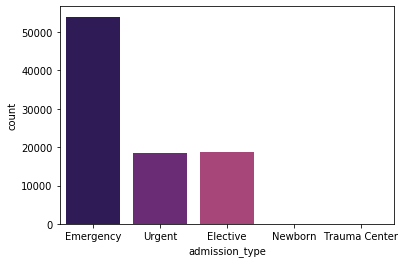

In [29]:
data['admission_type'].value_counts()

# you can try out value_counts()
# or plot using seaborn
sns.countplot(x='admission_type',data=data, palette='magma')
# sns.countplot(#define parameters inside)

#### Decoding Discharge Type

In medicine, "expired" is a term that describes a patient who has died. We only want to predict hospital readmission for living patients so we're going to remove hospital admissions in which the patient was recorded as "expired" upon being discharged in our dataset.

In [30]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'readmitted',
       'admission_type'],
      dtype='object')

In [33]:
discharge_disposition = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/diabetes/id_mappers/discharge_disposition_id.csv")
discharge_disposition

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpa...
5,6,Discharged/transferred to home with home healt...
6,7,Left AMA
7,8,Discharged/transferred to home under care of H...
8,9,Admitted as an inpatient to this hospital
9,10,Neonate discharged to another hospital for neo...


We'll first convert our `description` column to lowercase (`str.lower()`), then we'll search for rows that contain "expired" (`str.contains("expired")`). 

In [0]:
discharge_disposition['expired'] = discharge_disposition['description'].str.lower().str.contains('expired')

In [37]:
discharge_disposition.head(10)

,discharge_disposition_id,description,expired
0,1,Discharged to home,False
1,2,Discharged/transferred to another short term h...,False
2,3,Discharged/transferred to SNF,False
3,4,Discharged/transferred to ICF,False
4,5,Discharged/transferred to another type of inpa...,False
5,6,Discharged/transferred to home with home healt...,False
6,7,Left AMA,False
7,8,Discharged/transferred to home under care of H...,False
8,9,Admitted as an inpatient to this hospital,False
9,10,Neonate discharged to another hospital for neo...,False


Now let's take a look at all discharge dispositions that indicate an expired patient. We'll create a new dataframe that filters for rows in which the expired column is True.

In [38]:
discharge_expired = discharge_disposition[discharge_disposition['expired']==True]
discharge_expired

,discharge_disposition_id,description,expired
10,11,Expired,True
18,19,"Expired at home. Medicaid only, hospice.",True
19,20,"Expired in a medical facility. Medicaid only, ...",True
20,21,"Expired, place unknown. Medicaid only, hospice.",True


In [39]:
expired_ids = discharge_expired['discharge_disposition_id'].tolist()
expired_ids
# print(f"discharge_disposition_id's that indicate an expired patient: {expired_ids}")

[11, 19, 20, 21]

The next step is to remove all rows in our original dataset that has `discharge_disposition_id` equal to one of the values in our `expired_ids` list.

In [0]:
data = data[~data['discharge_disposition_id'].isin(expired_ids)]

Note the tilde (~) - means "bitwise not" 

After removing expired patients, how many patients do we have in our dataset?

In [41]:
n_patients_nonexpired = data['patient_nbr'].nunique()
print(f"Original number of patients: {n_patients:,}")
print(f"Number of expired patients: {n_patients-n_patients_nonexpired:,}")
print(f"After filtering out expired patients: {n_patients_nonexpired:,}")

Original number of patients: 71,518
Number of expired patients: 1,079
After filtering out expired patients: 70,439


#### Converting Medication Features From Categorical to Boolean

In our dataset, there are 24 columns that represent different types of medications. We're going to convert these medication columns into boolean variables. In Step 2, we created a list of medications. Let's see what a medication column looks like in our dataset. 

In [42]:
medications

['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [43]:
data[medications[0]].value_counts()

No        80216
Steady    18256
Up         1067
Down        575
Name: metformin, dtype: int64

Medication columns are currently categorical datatypes that have several possible categories including:

- "No" (not taking the medication)
- "Up" (increased medication dose)
- "Down" (decrease medication dose)
- "Steady" (no changes in dose)

To keep things simple, we'll update the column to "0" (not taking the medication) to "1" (taking the medication). We're losing out on information regarding their dose change, but it's a compromise we're willing to make in order to simplify our dataset.

We can use [numpy.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) to convert all instances of "No" to `0` and everything else (i.e., "Up", "Down", "Steady") to `1`. Let's loop through all medications and convert each column to boolean. We'll also drop our original medication column since we won't be needing it.

In [0]:
for m in medications:
  data[f'{m}_bool'] = ######
  data = data.drop(columns=m)

Our medication data are now represented as boolean features. Let's take a look at the prevelance of these medications. We'll calcualte the proportion of patients taking each type of medication. Because some patients have had multiple hospital admissions in this dataset, we'll need to do some wrangling to determine whether a patient was on a given medication during any of their admissions. The wrangling process consists of the following steps:

- applying `groupby` to `patient_nbr` and calculate the sum of admissions in which the patient was administered a medication
- convert the column to boolean such that patients that have "0" are False and "1" is True
- calculate the sum of patients on that specific medication
- calculate the proportion of patients who were administered that medication

In [0]:
prevalence = []

for m in medications:
    patient_meds = data.groupby('patient_nbr')[f'{m}_bool'].sum().reset_index()
    patient_meds[f'{m}_bool'] = patient_meds[f'{m}_bool'].astype(bool)
    n_patients_on_med = patient_meds[f'{m}_bool'].sum()
    proportion = n_patients_on_med/n_patients
    prevalence.append(proportion)

Now that we have a list of medication prevelance, we can create a dataframe and sort by prevelance to determine which medications are most prevalent in our dataset. 

In [0]:
# create dataframe with medication and prevalence columns
medication_counts = pd.DataFrame ### 
medication_counts = medication_counts.sort_values(by='prevalence', ascending=False)
medication_counts.head()

Let's visualize the top 10 most prevelant medications. We can use seaborn's [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) method.

In [0]:
# barplot

If you're not a medical doctor, it might be difficult to interpret what these medications mean. 

[MeSH](https://en.wikipedia.org/wiki/Medical_Subject_Headings) (or Medical Subject Headings) are a type of "tag" that describes a medical term. We'll use [RxNav's API](https://rxnav.nlm.nih.gov/RxNormAPIs.html#) to further investigate which MeSH terms are assocaited with our list of medications.

In [0]:
import json
import requests

def get_mesh_from_drug_name(drug_name):
    drug_name = drug_name.strip()
    rxclass_list = []
    try:
        r = requests.get(f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byDrugName.json?drugName={drug_name}&relaSource=MESH")
        response = r.json()
        all_concepts = response['rxclassDrugInfoList']['rxclassDrugInfo']
        for i in all_concepts:
            rxclass_list.append(i['rxclassMinConceptItem']['className'])
    except:
        pass
    return list(set(rxclass_list))

In [0]:
# get MeSH terms for each medication 
for m in medications:


#### Creating our Target Variable

The goal of our model will be to predict whether a patient will get readmitted to the hospital. Looking at the `readmitted` column, we see that there are 3 possible values: 

1. `NO` (not readmitted)
2. `>30` (readmitted more than 30 days after being discharged)
3. `<30` (readmitted within 30 days of being discharged)

In [0]:
data['readmitted'].value_counts()

Let's convert `readmitted` into a boolean column such that "NO" is 0 (not readmitted) and everything is 1 (did get readmitted). 

In [0]:
data['readmitted_bool'] = ####

## Step 4: Data Exploration and Visualization

#### Assessing Missing Values

To get a better sense of the missing values in our data, let's visualize it using [missingno](https://github.com/ResidentMario/missingno)'s "nullity" matrix.

In [0]:
import missingno as msno

msno.matrix(data)

### Patient Demographics

In [0]:
# let's plot age and gender

### What's the distribution of hospital stay length? How long was a stay on average?

In [0]:
# time_in_hospital
# sns.countplot

### How many medications were patients prescribed? 

In [0]:
# num_medications
# max number of medications
# average number of medications

# sns.kdeplot

### How many previous inpatient visits? Emergency Room visits?

In [0]:
# code here

# number_inpatient
# number_emergency

### Do patients have normal A1C levels?

The A1C blood test is used to diagnose whether a patient has type I or II diabetes, and represents the average levels of blood sugar over the past 3 months. The higher the A1C level, the poorer a patient's blood sugar control which indicates a higher risk of diabetes complications. The table below represents Mayo Clinic's [guideline](https://www.mayoclinic.org/tests-procedures/a1c-test/about/pac-20384643) of how to interpret A1C levels:

|interpretation|A1C level|
|-----------|--------|
|no diabetes|<5.7|
|pre-diabetes|5.7-6.4|
|diabetes|>6.5|
|well-managed diabetes|<7|
|poorly managed diabetes|>8|

Our dataset has a `A1Cresult` which reflects a patient's A1C level during their hospital stay. 

In [0]:
# code here

# A1Cresult

In [0]:
print(f"Proportion of hospital admissions with missing A1C: {}")

## Step 5: Feature Selection and Engineering

Our dataset contains quite a few categorical variables. In general, machine learning models can't handle categorical variables so we will need to apply one-hot encoding. 

### One-hot Encoding

Let's say we want to convert a patient’s race to a numerical feature. We could use label encoding to convert each race to values 0-5 but this suggests an inherent order among races that does not exist. With one-hot encoding, each race becomes an independent feature.

In [0]:
categorical = ['race', 'admission_type']

# pd.get_dummies

### Label Encoding

In [0]:
from sklearn.preprocessing import LabelEncoder

data['age_label'] = #
data['gender_bool'] = # 

## Step 6: Defining the X and y Variables

In [0]:
med_features = ['metformin_bool', 'repaglinide_bool',
    'nateglinide_bool', 'chlorpropamide_bool', 'glimepiride_bool',
    'acetohexamide_bool', 'glipizide_bool', 'glyburide_bool',
    'tolbutamide_bool', 'pioglitazone_bool', 'rosiglitazone_bool',
    'acarbose_bool', 'miglitol_bool', 'troglitazone_bool',
    'tolazamide_bool', 'examide_bool', 'citoglipton_bool', 'insulin_bool',
    'glyburide-metformin_bool', 'glipizide-metformin_bool',
    'glimepiride-pioglitazone_bool', 'metformin-rosiglitazone_bool',
    'metformin-pioglitazone_bool']

demographic_features = ['race_AfricanAmerican', 'race_Asian',
    'race_Caucasian', 'race_Hispanic', 'race_Other', 'age_label',
    'admission_type_Elective', 'admission_type_Newborn',
    'admission_type_Trauma Center', 'admission_type_Urgent', 'gender_bool']

other_features = ['num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']

all_features = med_features + demographic_features + other_features

X = data[all_features]

y = data['readmitted_bool']

## Step 7: Choosing our Binary Classification Model

When building a binary classification model, there are a wide selection of machine learning models to choose from:

- Random Forest Classification
- Logistic Regression
- Linear Discriminant Analysis
- Support Vector Machines (SVM)
- Gaussian Naive Bayes
- k-Nearest Neighbours

We’ll test out the Random Forest Classifier (RFC) for this dataset. RFC is an ensemble learning technique that works by creating a “forest” of decision trees. Each tree evaluates the data for a given patient and outputs a 0 or 1. Random Forest looks at the output of all trees and gives the majority vote as its result. Let’s say we have a forest with 3 trees and 2 of them predict the patient will be readmitted. The majority vote is that the patient will be readmitted.
<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/random_forest.png"/>

We’re choosing Random Forest because:
- it is robust to outliers
- it is able to handle unbalanced datasets
- it measures feature importance

In [0]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier().get_params()

## Step 8: Hyperparameter Tuning

Hyperparemter tuning is a critical step in the machine learning pipeline. It describes the process of choosing a set of optimal hyperparameters for a model. The hyperparameters that you select can have a significant impact on your model's performance. 

We're going to be testing out two hyperparameter tuning techniques offered by scikit-learn:

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/grid_search.png" align="right" width="20%"/>

With grid search, you define your search space as a grid of values and iterate over each grid point until you find the optimal combination of values. Let's say we want to tune `max_depth` and `n_estimators` in our RandomForestClassifer. We'll set our search space as follows:

- n_estimators = [5,10,50]
- max_depth = [3,5,10]

This means that we'll have to train our model 9 times to test for every configuration of values. We'll choose the combination of n_estimators and max_depth that give us the best model performance.

Let's implement this with scikit-learn's GridSearchCV. We first need to define our search space as a dictionary. We also need to initialize our model.

In [0]:
from sklearn.model_selection import GridSearchCV

# define search space 


# initialize model


In [0]:
grid_search = GridSearchCV()

grid_search.fit()

What are our optimal hyperparmaters?

In [0]:
print(f"Optimal hyperparameters: {}")
print(f"Best score: {}")

Here, our score uses RFC's default metric, [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score). If we want to optimize our model using another metric, we can specify `scoring = 'precision'` (or whichever metric we're interested in) inside GridSearchCV.

We can also see a thorough report of our results with `cv_results_`. It shows fit time, score time, and mean train/test score (averaged over all folds). We'll sort by `mean_test_score`.

In [0]:
# grid_search.cv_results_

In 2012, Bergstra and Bengio from the University of Montreal proposed a new technique called [random search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) which is similar to grid search but instead of sampling over a discrete set of values, you’re now randomly sampling from a distribution of values. Random search is effective in situations where not all hyperparameters are equally important.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/random_grid_search.png" width="50%"/>

The visualization above gives an example of when random search can perform better. With grid search, you’re only looking at 3 different values of a given hyperparamter. But with random search you’re looking at nine different values. As you increase the number of samples in your random search, you increase the probability of finding the optimal hyperparameters for your model. 

Let's test out random search using scikit-learn's RandomizedSearchCV. We'll define our search space over a uniform distribution of values. We'll iterate 9 times, just like we did for grid search. 

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# define search space

# define random search object

In [0]:
print(f"Optimal hyperparamters: {}")
print(f"Best score: {}")

Grid Search and Random Search are uninformed methods. If you're working with a very large search space, it might be a good idea to use a "smarter" approach such as [Sequential-Based Model Optimization](https://www.cs.ubc.ca/~hutter/papers/10-TR-SMAC.pdf). 

The SMBO approach keeps track of previous iteration results which is used to sample hyperapramters at the current iteration. In other words, SMBO is trying to reduce the number of iterations by sampling the most promising hyperparameters based on past results. You can check out [scikit-optimize](https://scikit-optimize.github.io/) to learn more about how to implement SMBO hyperparameter tuning with scikit-learn models.

## Step 9: Evaluating Model Performance

There are several metrics that we can use to evaluate model performance:

- accuracy
- precision
- recall
- F1-score

We'll focus on accuracy, precision, and recall.

In [0]:
from sklearn.model_selection import train_test_split

# split X and y into train and test sets
# initialize model with best_params from Random Search or Grid Search
# fit model with X_train and y_train
# evaluate model with X_test and y_test

### Precision and Recall

Precision and recall are information retrieval metrics that evaluate classification models.

- Precision: “What proportion of predicted readmitted patients were actually readmitted?”
- Recall: “What proportion of readmitted patients were identified correctly?”

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/precision_recall.png" width="70%"/>

In [0]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = #### 

precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)

#### Confusion Matrix

Another way to assess our model’s performance is to visualize our results with a confusion matrix.

In [0]:
labels = np.array([['TN','FP'],['FN','TP']])

confusion = ### confusion matrix

sns.heatmap(confusion, annot=labels, fmt='', linewidths=2, cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("actual")

## Step 10: Examining Feature Importance

In [0]:
# code here

feature_importances = #